# Deep Learning in Human Language Technologies 2020
# Text classification project

In [1]:
import numpy as np
import pandas as pd
import seaborn as sns

from matplotlib import pyplot as plt
from nltk.stem.snowball import SnowballStemmer
from nltk.corpus import stopwords
from pathlib import Path
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.metrics import confusion_matrix
from sklearn.naive_bayes import MultinomialNB
from sklearn.preprocessing import LabelEncoder
from sklearn.utils import class_weight
from tensorflow.keras import optimizers
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint
from tensorflow.keras.layers import Dense, Dropout, Embedding, Input, LSTM, SimpleRNN
from tensorflow.keras.models import Model
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.preprocessing.text import Tokenizer

## Building the dataset

A mapping for the registers:

In [2]:
register_map = {
    'NA': {
        'description': 'Narrative',
        'sub': {
            'NE': 'New reports / news blogs', 
            'SR': 'Sports reports',
            'PB': 'Personal blog', 
            'HA': 'Historical article',
            'FC': 'Fiction', 
            'TB': 'Travel blog',
            'CB': 'Community blogs', 
            'OA': 'Online article',
        }
    },
    'OP': {
        'description': 'Opinion',
        'sub': {
            'OB': 'Personal opinion blogs', 
            'RV': 'Reviews',
            'RS': 'Religious blogs/sermons',
            'AV': 'Advice',
        }
    },
    'IN': {
        'description': 'Informal description',
        'sub': {
            'JD': 'Job description', 
            'FA': 'FAQs',
            'DT': 'Description of a thing', 
            'IB': 'Information blogs',
            'DP': 'Description of a person',
            'RA': 'Research articles',
            'LT': 'Legal terms / conditions',
            'CM': 'Course materials',
            'EN': 'Encyclopedia articles',
            'RP': 'Report',
        }
    },
    'ID': {
        'description': 'Interactive discussion',
        'sub': {
            'DF': 'Discussion forums',
            'QA': 'Question-answer forums',
        }
    },
    'HI': {
        'description': 'How-to/instructions',
        'sub': {
            'RE': 'Recipes',
        }
    },
    'IP': {
        'description': 'Informational persuasion',
        'sub': {
        }
    },
    'IG': {
        'description': 'Informational persuasion',
        'sub': {
            'DS': 'Description with intent to sell',
            'EB': 'News-opinion blogs / editorials',
        }
    },
    'LY': {
        'description': 'Lyrical',
        'sub': {
            'PO': 'Poems',
            'SL': 'Songs',
        }
    },
    'SP': {
        'description': 'Spoken',
        'sub': {
            'IT': 'Interviews', 
            'FS': 'Formal speeches',
        }
    },
    'OS': {
        'description': 'Others',
        'sub': {
             'MT': 'Machine-translated / generated texts',
        }
    }
}

Lists of high-level and sub-level registers. These are used to construct register-based columns in the Pandas DataFrames:

In [3]:
# high level registers
hl_reg = list(register_map.keys())
# sub level registers
sl_reg = [s for sublist in register_map.values() for s in sublist['sub'].keys()]

Construct the DataFrames:

In [4]:
print("Generating DataFrames.")
orig_columns = ['reg', 'text', 'hl_reg']

# load the data
df_train = pd.read_csv('fincore-train.tsv', sep='\t', names=orig_columns)
df_train = df_train.sample(frac=1, random_state=42).reset_index(drop=True)
df_train = df_train.reindex(columns=orig_columns + hl_reg + sl_reg)

df_dev = pd.read_csv('fincore-dev.tsv', sep='\t', names=orig_columns)
df_dev = df_dev.sample(frac=1, random_state=42).reset_index(drop=True)
df_dev = df_dev.reindex(columns=orig_columns + hl_reg + sl_reg)

df_test = pd.read_csv('fincore-test.tsv', sep='\t', names=orig_columns)
df_test = df_test.sample(frac=1, random_state=42).reset_index(drop=True)
df_test = df_test.reindex(columns=orig_columns + hl_reg + sl_reg)

# nested loops go brrrrrrrr.....
for df in [df_train, df_dev, df_test]:
    # figure out the registers the sample belongs to
    df.reg = df.reg.apply(lambda x: x.strip(' ').replace(' ', '_'))
    df[hl_reg + sl_reg] = 0
    for idx, row in df.iterrows():
        hl = '_'
        for reg in row.reg.split('_'):
            if not reg:
                continue
            if reg in hl_reg:
                hl += f'{reg}_'
            # e.g. if 'reg' == 'NA NE" => registers NA and NE are 1, rest 0
            df.iloc[idx, df.columns.get_loc(reg)] = 1
        df.iloc[idx, df.columns.get_loc('hl_reg')] = hl.strip('_')
print("Done.")

Generating DataFrames.
Done.


The constructed DataFrame is of the following form:

In [5]:
df_train.head()

,reg,text,hl_reg,NA,OP,IN,ID,HI,IP,IG,...,DF,QA,RE,DS,EB,PO,SL,IT,FS,MT
0,CB_NA,lauantai Lauantai oli taas mukavan kylmä päiv...,NA,1,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,DT_IN,"Aurinkolämmöllä tarkoitetaan järjestelmää , j...",IN,0,0,1,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,PB_NA,Sivut torstai 14. kesäkuuta 2012 Vaihde vapaa...,NA,1,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,HI,Valitse kieli : Hae rahoitusta EEP-rahoitusta...,HI,0,0,0,0,1,0,0,...,0,0,0,0,0,0,0,0,0,0
4,PB_NA,"Friday , 13 May 2011 Näin aika kuluu Vanhoja ...",NA,1,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


## Milestone 1

Data for the first milestone:

In [6]:
# alternative max_features params for CountVectorizer
max_features_options = [1000, 10000, 20000, 30000, 40000]

# what labels are included in the training data?
train_labels = set(df_train.reg)

# only dev / test rows the labels of which are present in the training data
df_dev_ms1 = df_dev[df_dev.reg.isin(train_labels)]
df_test_ms1 = df_test[df_test.reg.isin(train_labels)]

# texts for all datasets, both normal and Voikko-transformed
texts = {
    'train': [x for x in df_train.text],
    'dev': [x for x in df_dev_ms1.text],
    'test': [x for x in df_test_ms1.text],
}

# labels as numbers
label_encoder = LabelEncoder()
train_classes = label_encoder.fit_transform(df_train.reg)
dev_classes = label_encoder.transform(df_dev_ms1.reg)
test_classes = label_encoder.transform(df_test_ms1.reg)

# likewise for the high-level predictor only
label_encoder_hl = LabelEncoder()
train_classes_hl = label_encoder_hl.fit_transform(df_train.hl_reg)
dev_classes_hl = label_encoder_hl.transform(df_dev_ms1.hl_reg)
test_classes_hl = label_encoder_hl.transform(df_test_ms1.hl_reg)
test_classes_hl_names = set(df_test_ms1.hl_reg.values)

print("Generating Milestone 1 data.")
ms1_data = {}

for mf in max_features_options:
    # generate a vectorizer and feature matrices for this particular
    # max_features param (stored in mf)
    vectorizer = CountVectorizer(max_features=mf,
                                 binary=True,
                                 ngram_range=(1, 1))
    ms1_data[mf] = {
        'vectorizer': vectorizer,
        'train_feature_matrix': vectorizer.fit_transform(texts['train']),
        'dev_feature_matrix': vectorizer.transform(texts['dev']),
        'test_feature_matrix':  vectorizer.transform(texts['test'])
    }
            
print("Done.")

Generating Milestone 1 data.
Done.


### 1.0: Baseline (naive Bayes)

Naive Bayes classifier to be used as a baseline. It is trained on the training data for each separate dataset (different _max_features_ params for the CountVectorizer). Additionally accuracy on the permutated test sets are computed for the purpose of ensuring that performance with actual data differs from performance with junk data.

In [7]:
def mnb_compute(X, y, mnb):
    predictions = mnb.predict(X)
    return (np.sum(predictions == y) / len(y), predictions)

bayes_results = {}
for max_feats, stats in ms1_data.items():
    # train using the training set
    mnb = MultinomialNB()
    mnb.fit(stats['train_feature_matrix'], df_train.reg)

    # accuracies for all the real sets
    train_accuracy, _ = mnb_compute(
        stats['train_feature_matrix'], df_train.reg, mnb)

    dev_accuracy, _ = mnb_compute(
        stats['dev_feature_matrix'], df_dev_ms1.reg, mnb)

    test_accuracy, test_predictions = mnb_compute(
        stats['test_feature_matrix'], df_test_ms1.reg, mnb)
    
    # accuracy on permutated test set
    perm_accuracy, _ = mnb_compute(
        stats['test_feature_matrix'],
        np.random.permutation(df_test_ms1.reg),
        mnb
    )

    # train using the training set and only high-level registers
    mnb_hl = MultinomialNB()
    mnb_hl.fit(stats['train_feature_matrix'], df_train.hl_reg)
    
    # accuracies for just the high-level registers
    train_accuracy_hl, _ = mnb_compute(
        stats['train_feature_matrix'], df_train.hl_reg, mnb_hl)

    dev_accuracy_hl, _ = mnb_compute(
        stats['dev_feature_matrix'], df_dev_ms1.hl_reg, mnb_hl)

    test_accuracy_hl, test_predictions_hl = mnb_compute(
        stats['test_feature_matrix'], df_test_ms1.hl_reg, mnb_hl)
    
    # confusion matrix for the high-level case
    conf_matrix_hl = None
    if max_feats == 30000: 
        conf_matrix_hl = pd.DataFrame(
            confusion_matrix(df_test_ms1.hl_reg, test_predictions_hl),
            index=[f"{c} ({len(df_test_ms1[df_test_ms1.hl_reg == c])})"
                   for c in mnb_hl.classes_ if c in test_classes_hl_names],
            columns=[c for c in mnb_hl.classes_ if c in test_classes_hl_names]
        )
    
    bayes_results[max_feats] = {
        'model': mnb,
        'model_hl': mnb_hl,
        'train_accuracy': train_accuracy,
        'dev_accuracy': dev_accuracy,
        'test_accuracy': test_accuracy,
        'test_predictions': test_predictions,
        'perm_accuracy': perm_accuracy,
        'train_accuracy_hl': train_accuracy_hl,
        'dev_accuracy_hl': dev_accuracy_hl,
        'test_accuracy_hl': test_accuracy_hl,
        'test_predictions_hl': test_predictions_hl,
        'conf_matrix_hl': conf_matrix_hl
    }

In [8]:
for mf, stats in bayes_results.items():
    print(f"\nMax features: {mf}\nACCURACY: "
          f"Train {stats['train_accuracy']:.2f}  "
          f"Dev {stats['dev_accuracy']:.2f}  "
          f"Test {stats['test_accuracy']:.2f}  "
          "\tHIGH-LEVEL ACCURACY: "
          f"Train {stats['train_accuracy_hl']:.2f}  "
          f"Dev {stats['dev_accuracy_hl']:.2f}  "
          f"Test {stats['test_accuracy_hl']:.2f}  ")


Max features: 1000
ACCURACY: Train 0.68  Dev 0.53  Test 0.50  	HIGH-LEVEL ACCURACY: Train 0.60  Dev 0.54  Test 0.53  

Max features: 10000
ACCURACY: Train 0.81  Dev 0.59  Test 0.56  	HIGH-LEVEL ACCURACY: Train 0.73  Dev 0.63  Test 0.59  

Max features: 20000
ACCURACY: Train 0.81  Dev 0.56  Test 0.55  	HIGH-LEVEL ACCURACY: Train 0.78  Dev 0.65  Test 0.62  

Max features: 30000
ACCURACY: Train 0.80  Dev 0.56  Test 0.54  	HIGH-LEVEL ACCURACY: Train 0.80  Dev 0.66  Test 0.63  

Max features: 40000
ACCURACY: Train 0.78  Dev 0.55  Test 0.52  	HIGH-LEVEL ACCURACY: Train 0.82  Dev 0.65  Test 0.62  


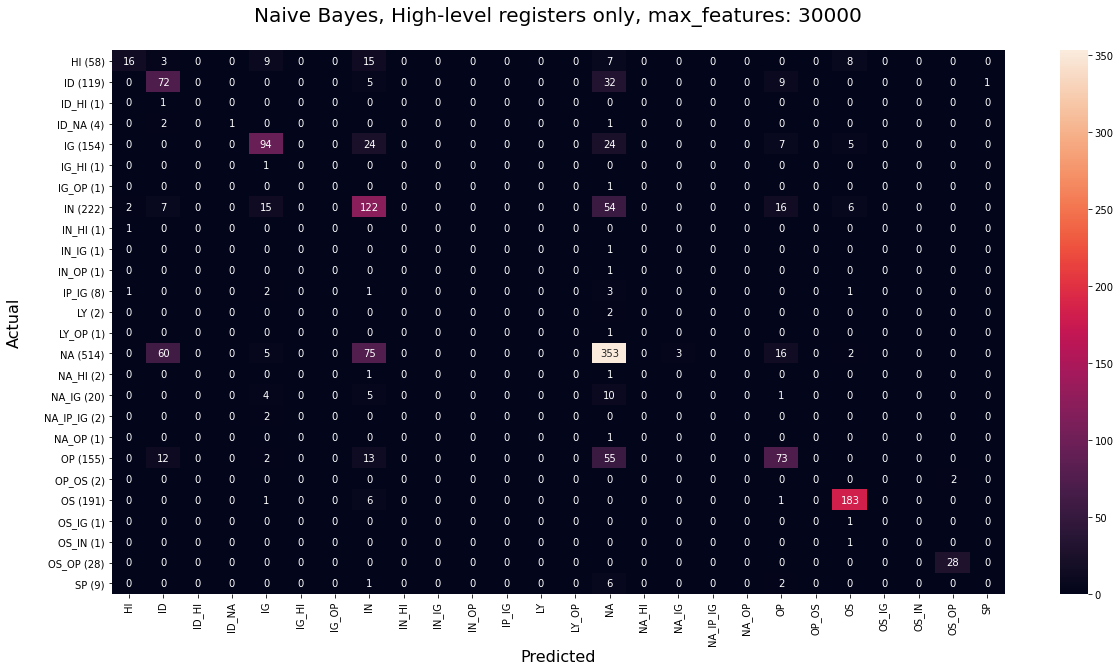

In [9]:
plt.figure(figsize=(20, 10))
sns.heatmap(bayes_results[30000]['conf_matrix_hl'], annot=True, fmt='d')
plt.title("Naive Bayes, High-level registers only, max_features: 30000\n", fontsize=20)
plt.ylabel('Actual\n', fontsize=16)
plt.xlabel('Predicted', fontsize=16)
plt.show()

### 1.1: BOW

In [10]:
example_count = len(df_train)
class_count = len(label_encoder.classes_)
class_count_hl = len(label_encoder_hl.classes_)

keras_optimizers = {
    'SGD': optimizers.SGD(),
    'Adam': optimizers.Adam(),
    #'AdaDelta': optimizers.Adadelta(),
    #'AdaGrad': optimizers.Adagrad(),
    #'RMSprop': optimizers.RMSprop(),
    #'Nadam': optimizers.Nadam(),
}

def train_bow(train_cls_num, dev_cls_num, test_cls_num, make_cm=[], weights=None):
    results = {}
    for max_feats, stats in ms1_data.items():
        results[max_feats] = {}
        for optim_name, optimizer in keras_optimizers.items():
            print(f"Training with params:\toptimizer = {optim_name.ljust(20, ' ')}"
                  f"CountVectorizer.max_features = {max_feats}") 

            train_fm = stats['train_feature_matrix']
            dev_fm = stats['dev_feature_matrix']
            test_fm = stats['test_feature_matrix']

            inp = Input(shape=(max_feats,))
            hidden1 = Dense(300, activation="relu")(inp)
            hidden2 = Dense(300, activation="relu")(hidden1)
            dropout = Dropout(0.3)(hidden2)
            outp = Dense(class_count, activation='softmax')(dropout)
            model = Model(inputs=[inp], outputs=[outp])

            model.compile(optimizer=optimizer,
                          loss='sparse_categorical_crossentropy',
                          metrics=['accuracy'])

            mc = ModelCheckpoint(filepath='/tmp/bow_model.h5',
                                 monitor='val_loss',
                                 verbose=0,
                                 save_best_only=True,
                                 mode='auto')

            es = EarlyStopping(monitor='val_loss',
                               patience=40,
                               verbose=0,
                               restore_best_weights=True)

            fit_params = {
                'batch_size': 32,
                'verbose': 0,
                'epochs': 100,
                'callbacks': [mc, es],
                'validation_data': (dev_fm.toarray(), dev_cls_num)
            }
            
            # optional weights 
            if weights is not None:
                fit_params['class_weight'] = weights

            hist = model.fit(train_fm.toarray(),
                             train_cls_num,
                             **fit_params)

            results[max_feats][optim_name] = {
                'model': model,
                'hist': hist,
                'results': {}
            }

            for name, fm_cls in zip (['train', 'dev', 'test'],
                                     [(train_fm, train_cls_num),
                                      (dev_fm, dev_cls_num),
                                      (test_fm, test_cls_num)]):
                fm, cls_num = fm_cls
                preds = np.argmax(model.predict(fm.toarray()), axis=1)
                acc = np.sum(np.equal(cls_num, preds)) / len(cls_num)
                
                # confusion matrix
                conf_matrix = None
                if max_feats in make_cm and name == 'test':
                    y_true = [label_encoder_hl.inverse_transform([i])[0]
                              for i in cls_num]
                    y_pred = [label_encoder_hl.inverse_transform([i])[0]
                              for i in preds]
                    cmc = sorted(set(y_true))
                    cmi=[f"{c} ({len(df_test_ms1[df_test_ms1.hl_reg == c])})"
                         for c in cmc]
                    conf_matrix = pd.DataFrame(
                        confusion_matrix(y_true, y_pred), index=cmi, columns=cmc)
                
                results[max_feats][optim_name]['results'][name] = {
                    'accuracy': acc,
                    'preds': preds,
                    'conf_matrix': conf_matrix,
                }
                
    print("Done.")
    return results

Initialize a dict for results:

In [11]:
bow_results = {'full': {}, 'hl': {}}

Compute the normal results:

In [12]:
print("BOW for full data (all registers)")
bow_results['full'] = train_bow(train_classes, dev_classes, test_classes)

BOW for full data (all registers)
Training with params:	optimizer = SGD                 CountVectorizer.max_features = 1000
Training with params:	optimizer = Adam                CountVectorizer.max_features = 1000
Training with params:	optimizer = SGD                 CountVectorizer.max_features = 10000
Training with params:	optimizer = Adam                CountVectorizer.max_features = 10000
Training with params:	optimizer = SGD                 CountVectorizer.max_features = 20000
Training with params:	optimizer = Adam                CountVectorizer.max_features = 20000
Training with params:	optimizer = SGD                 CountVectorizer.max_features = 30000
Training with params:	optimizer = Adam                CountVectorizer.max_features = 30000
Training with params:	optimizer = SGD                 CountVectorizer.max_features = 40000
Training with params:	optimizer = Adam                CountVectorizer.max_features = 40000
Done.


Compute the predictions for high-level registers only:

In [13]:
print("BOW for high-level registers")
weights = class_weight.compute_class_weight(
    'balanced', np.unique(df_test_ms1.hl_reg), df_test_ms1.hl_reg)
bow_results['hl'] = train_bow(train_classes_hl, dev_classes_hl, test_classes_hl,
                              make_cm=[30000], weights=weights)

BOW for high-level registers
Training with params:	optimizer = SGD                 CountVectorizer.max_features = 1000
Training with params:	optimizer = Adam                CountVectorizer.max_features = 1000
Training with params:	optimizer = SGD                 CountVectorizer.max_features = 10000
Training with params:	optimizer = Adam                CountVectorizer.max_features = 10000
Training with params:	optimizer = SGD                 CountVectorizer.max_features = 20000
Training with params:	optimizer = Adam                CountVectorizer.max_features = 20000
Training with params:	optimizer = SGD                 CountVectorizer.max_features = 30000
Training with params:	optimizer = Adam                CountVectorizer.max_features = 30000
Training with params:	optimizer = SGD                 CountVectorizer.max_features = 40000
Training with params:	optimizer = Adam                CountVectorizer.max_features = 40000
Done.


A function for plotting the graphs:

In [14]:
def plot_results(results, title):
    fig, ax = plt.subplots(max(len(keras_optimizers), 2),
                           max(len(max_features_options), 2),
                           figsize=(15, 8),
                           sharey=True,
                           tight_layout=True)
    plt.suptitle(f"{title}\n", va='baseline', fontsize=20)
    for mf_idx, (mf, optim_stats) in enumerate(bow_results['hl'].items()):
        for optim_idx, (optim, stats) in enumerate(optim_stats.items()):
            hist = stats['model'].history.history
            ax[optim_idx][mf_idx].set_title(f"Max_features: {mf}\n"
                                            f"Optimizer: {optim}",
                                            fontsize=12)
            ax[optim_idx][mf_idx].plot(hist['accuracy'], label='training')
            ax[optim_idx][mf_idx].plot(hist['val_accuracy'], label='validation')
            ax[optim_idx][mf_idx].set_xlabel(
                f"Train accuracy: {stats['results']['train']['accuracy']:.2f}"
                f"\nDev accuracy: {stats['results']['dev']['accuracy']:.2f}"
                f"\nTest accuracy: {stats['results']['test']['accuracy']:.2f}\n",
                fontsize=12
            )
            ax[optim_idx][mf_idx].legend(loc='lower right')
    plt.show()

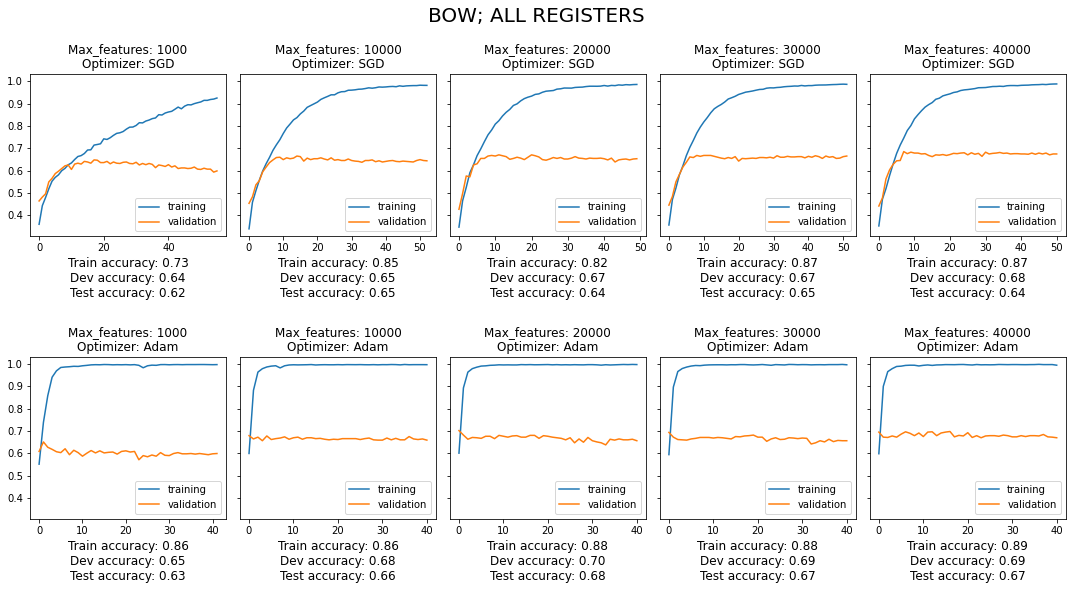

In [15]:
plot_results(bow_results['full'], 'BOW; ALL REGISTERS')

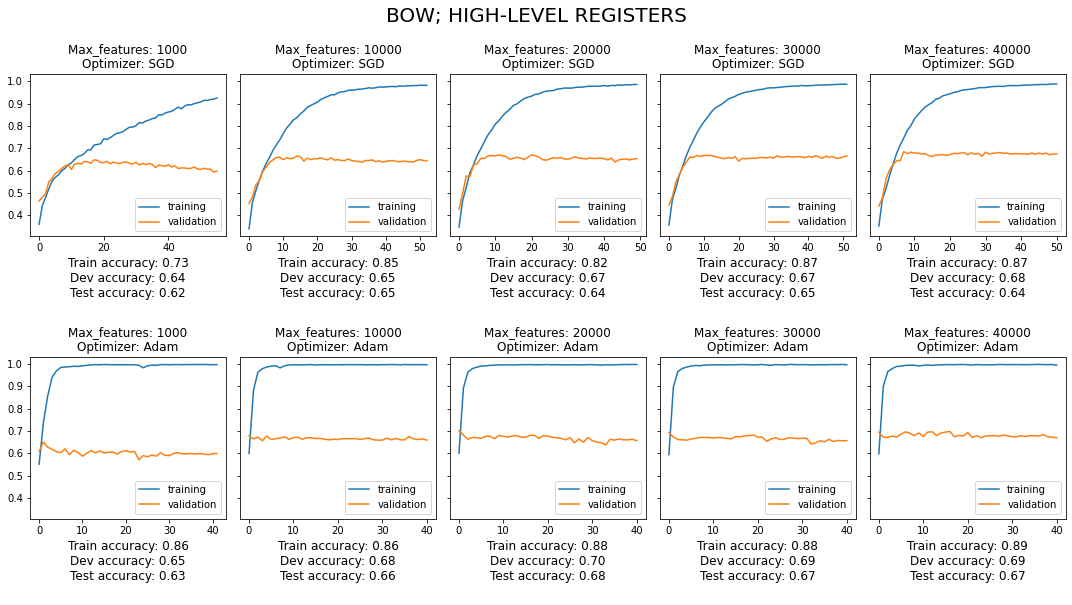

In [18]:
plot_results(bow_results['hl'], 'BOW; HIGH-LEVEL REGISTERS')

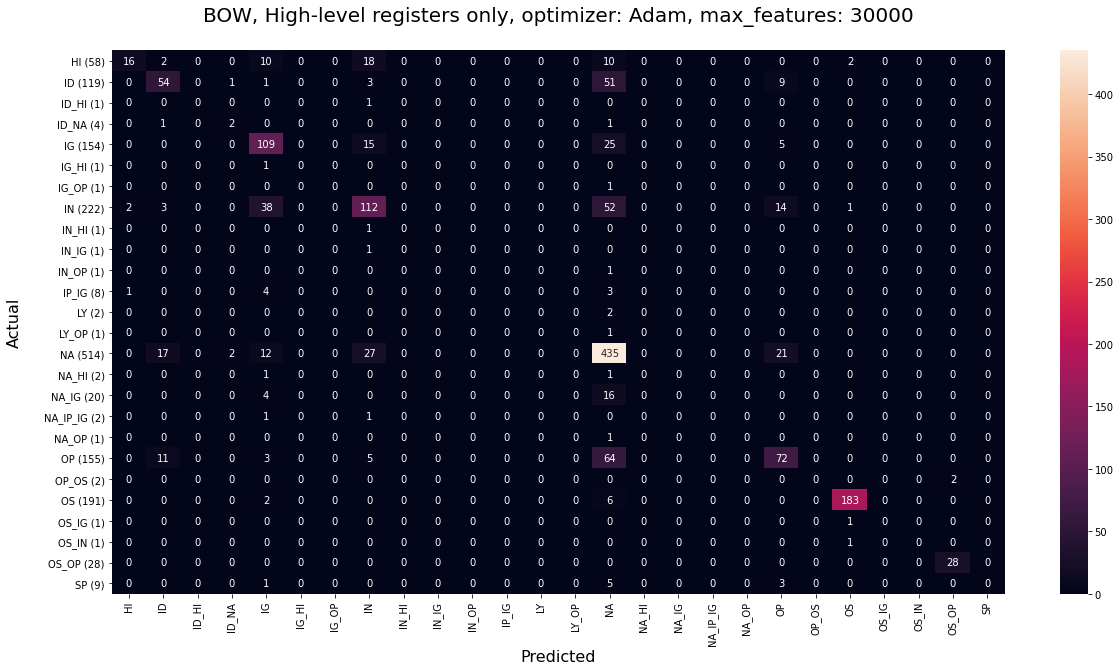

In [19]:
plt.figure(figsize=(20, 10))
sns.heatmap(bow_results['hl'][30000]['Adam']['results']['test']['conf_matrix'], annot=True, fmt='d')
plt.title("BOW, High-level registers only, optimizer: Adam, max_features: 30000\n", fontsize=20)
plt.ylabel('Actual\n', fontsize=16)
plt.xlabel('Predicted', fontsize=16)
plt.show()

### 1.2: RNN

In [ ]:
tokenizer = Tokenizer(num_words=100000, lower=True, split=' ', char_level=False)
tokenizer.fit_on_texts(texts['normal']['train'])
train_seq = tokenizer.texts_to_sequences(texts['normal']['train'])
dev_seq = tokenizer.texts_to_sequences(texts['normal']['dev'])
test_seq = tokenizer.texts_to_sequences(texts['normal']['test'])

In [ ]:
train_lens = [len(s) for s in train_seq]
dev_lens = [len(s) for s in dev_seq]
test_lens = [len(s) for s in test_seq]

train_max_len, train_min_len, train_mean_len = max(train_lens), min(train_lens), int(np.mean(train_lens))
dev_max_len, dev_min_len, dev_mean_len = max(dev_lens), min(dev_lens), int(np.mean(dev_lens))
test_max_len, test_min_len, test_mean_len = max(test_lens), min(test_lens), int(np.mean(test_lens))

In [ ]:
print(train_max_len, dev_max_len, test_max_len)
print(train_min_len, dev_min_len, test_min_len)
print(train_mean_len, dev_mean_len, test_mean_len)

In [ ]:
train_seq = pad_sequences(train_seq,
                          250,
                          padding='post', 
                          truncating='post',
                          value=0)

dev_seq = pad_sequences(dev_seq,
                        250,
                        padding='post', 
                        truncating='post',
                        value=0)

test_seq = pad_sequences(test_seq,
                         250,
                         padding='post', 
                         truncating='post',
                         value=0)

In [ ]:
def build_rnn_model(RNN_class, 
                    sequence_length, 
                    vocab_size,
                    num_classes,
                    embedding_dim=250,
                    rnn_units=50):
    
    input_ = Input(shape=(sequence_length,))
    embedding = Embedding(vocab_size, embedding_dim)(input_)
    # return_sequences=False is the default
    rnn = RNN_class(rnn_units, return_sequences=False)(embedding)
    output = Dense(num_classes, activation='softmax')(rnn)
    return Model(inputs=[input_], outputs=[output])  

In [ ]:
lstm_model = build_rnn_model(LSTM, 250, tokenizer.num_words, len(train_labels), embedding_dim=250)
lstm_model.compile(loss='sparse_categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
lstm_history = lstm_model.fit(train_seq, train_class_numbers, epochs=3, batch_size=1, validation_split=0.1)

In [ ]:
"""
simple_model = build_rnn_model(SimpleRNN, train_max_len, tokenizer.num_words, len(train_labels))
simple_model.compile(loss='sparse_categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
simple_history = simple_model.fit(train_seq, train_class_numbers, epochs=3, batch_size=1, validation_split=0.1, verbose=1)
"""
pass